### A neural network that uses patient health data to determine the risk of heart attack. The features consist of various aspects of patients' physiology and the label is a determination (by a doctor) of a high or low risk of heart attack.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.model_selection import train_test_split

cd = Path.cwd()
filename = 'heart'
filename += '.csv'

path = os.path.join(cd,'Downloads',filename)

df = pd.read_csv(path)
df.rename(columns={'age':'Age',
                   'cp':'Chest Pain Type',
                  'trestbps':'Resting Blood Pressure',
                  'chol':'Serum Cholestoral in mg/dl',
                  'fbs':'Fasting Blood Sugar > 120 mg/dl',
                  'restecg':'Resting ECG Results',
                  'thalach':'Maximum Heart Rate',
                  'exang':'Exercise Induced Angina',
                  'oldpeak':'ST Depression Induced by Exercise',
                  'slope':'Slope of Peak Exercise ST Segment',
                  'ca':'Major Vessels Colored by Flourosopy',
                  'thal':'Defect (Normal/Fixed/Reversable)',
                  'target':'High Risk of Heart Attack'},
         inplace=True)

df

,Age,sex,Chest Pain Type,Resting Blood Pressure,Serum Cholestoral in mg/dl,Fasting Blood Sugar > 120 mg/dl,Resting ECG Results,Maximum Heart Rate,Exercise Induced Angina,ST Depression Induced by Exercise,Slope of Peak Exercise ST Segment,Major Vessels Colored by Flourosopy,Defect (Normal/Fixed/Reversable),High Risk of Heart Attack
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### All columns are scaled to values between 0 and 1 using the maximum and minimum of each column in the training data.

In [2]:
X = df.drop(['High Risk of Heart Attack'],axis=1)
y = df['High Risk of Heart Attack']
batch_size = 24

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=batch_size)
test_df = X_test.reset_index().drop(['index'],axis=1).astype('int32')
X_train = np.array(X_train)
X_test = np.array(X_test)

for col in range(X.shape[1]):
    col_max = X_train[:,col].max()
    col_min = X_train[:,col].min()
    d = col_max - col_min
    X_train[:,col] = (X_train[:,col] - col_min)/d
    X_test[:,col] = (X_test[:,col] - col_min)/d

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.batch(batch_size).shuffle(batch_size*2).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:
l2 = keras.regularizers.L2(2e-3)

model = keras.Sequential([
    keras.layers.Dense(55,activation='relu',input_shape=(X_train.shape[1],),kernel_regularizer='l1'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(55,activation='relu',kernel_regularizer=l2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(55,activation='relu',kernel_regularizer=l2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1,activation='sigmoid')
])

optimizer = keras.optimizers.Adam(learning_rate=2e-3)

model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy',keras.metrics.Recall(name='recall')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 55)                770       
                                                                 
 batch_normalization (BatchN  (None, 55)               220       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 55)                3080      
                                                                 
 batch_normalization_1 (Batc  (None, 55)               220       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 55)                3080      
                                                                 
 batch_normalization_2 (Batc  (None, 55)               2

### Since training can be eratic (with the model sometimes worsening over more epochs), the weights with the best accuracy on the test data are saved and used for the final model.

In [5]:
epochs = 112

weights_path = 'heart-attack-model-weights.h5'

checkpoint = keras.callbacks.ModelCheckpoint(weights_path,
                                            verbose=1,
                                            save_best_only=True,
                                            save_weights_only=True,
                                            monitor='val_accuracy')

history = model.fit(train_dataset,
                   validation_data=test_dataset,
                   epochs=epochs,
                   callbacks=[checkpoint])

Epoch 1/112
12/12 [==============================] - ETA: 0s - loss: 1.8194 - accuracy: 0.7133 - recall: 0.7467 
Epoch 00001: val_accuracy improved from -inf to 0.70833, saving model to heart-attack-model-weights.h5
12/12 [==============================] - 4s 74ms/step - loss: 1.8194 - accuracy: 0.7133 - recall: 0.7467 - val_loss: 1.8887 - val_accuracy: 0.7083 - val_recall: 1.0000
Epoch 2/112
12/12 [==============================] - ETA: 0s - loss: 1.5406 - accuracy: 0.8495 - recall: 0.8800
Epoch 00002: val_accuracy did not improve from 0.70833
12/12 [==============================] - 0s 7ms/step - loss: 1.5406 - accuracy: 0.8495 - recall: 0.8800 - val_loss: 1.8313 - val_accuracy: 0.7083 - val_recall: 1.0000
Epoch 3/112
 1/12 [=>............................] - ETA: 0s - loss: 1.5378 - accuracy: 0.8750 - recall: 0.8667
Epoch 00003: val_accuracy improved from 0.70833 to 0.79167, saving model to heart-attack-model-weights.h5
12/12 [==============================] - 0s 11ms/step - loss: 1.

### The following charts display the loss, accuracy, and recall of the model through all the epochs. Practically, the most important metric is recall, because it's better the catch all instances of heart disease than to miss even a few, and so the model was optimized for recall.

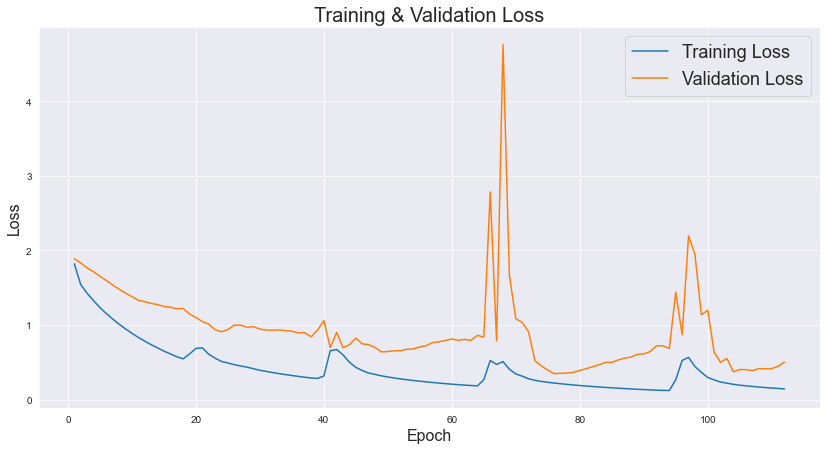

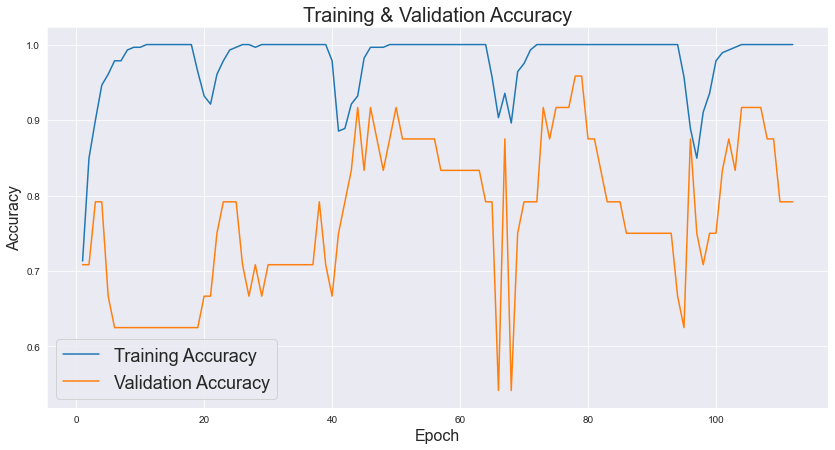

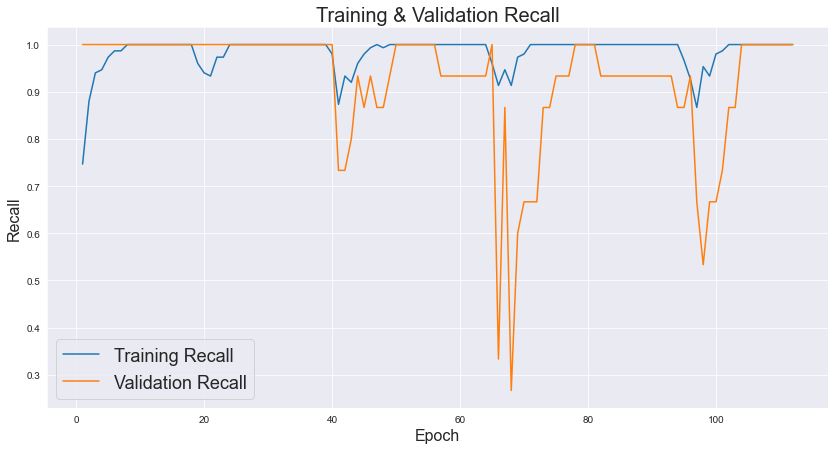

1/1 [==============================] - 0s 28ms/step - loss: 0.3571 - accuracy: 0.9583 - recall: 1.0000

Final loss on test data: 0.36
Final accuracy on test data: 0.96
Final recall on test data: 1.0


In [6]:
hist = history.history

sns.set_style('darkgrid')
def plot_metric(metric,grid_start=0):
    train_metric = hist[metric][grid_start:]
    val_metric = hist['val_' + metric][grid_start:]
    epoch = (np.arange(epochs) + 1)[grid_start:]
    plt.figure(figsize=(14,7))
    plt.plot(epoch,train_metric)
    plt.plot(epoch,val_metric)
    title = 'Training & Validation ' + metric.title()
    plt.title(title,fontdict={'fontsize':20})
    plt.xlabel('Epoch',fontdict={'fontsize':16})
    plt.ylabel(metric.title(),fontdict={'fontsize':16})
    plt.legend(['Training '+metric.title(),
               'Validation '+metric.title()],prop={'size':18})
    plt.show()
    
plot_metric('loss')
plot_metric('accuracy')
plot_metric('recall')

model.load_weights(weights_path)
val_loss,val_accuracy,val_recall = model.evaluate(test_dataset)

print('\nFinal loss on test data: ' + str(round(val_loss,2)))
print('Final accuracy on test data: ' + str(round(val_accuracy,2)))
print('Final recall on test data: ' + str(round(val_recall,2)))

### The table below shows the test data with the correct labels, as well as the model's predictions of heart attack risk in terms of percentage (i.e. the model predicts how likely it is, based on a patient's health data, for a doctor to declare that patient as having a high risk of a heart attack.)

In [7]:
predictions = model.predict(X_test).squeeze()
percentage = (predictions*100).astype('int').astype('str')
percentage = pd.Series(percentage) + '%'

test_df['High Risk of Heart Attack'] = np.array(y_test)
test_df['Prediction of Heart Attack Risk'] = percentage
test_df.style.hide_index()

Age,sex,Chest Pain Type,Resting Blood Pressure,Serum Cholestoral in mg/dl,Fasting Blood Sugar > 120 mg/dl,Resting ECG Results,Maximum Heart Rate,Exercise Induced Angina,ST Depression Induced by Exercise,Slope of Peak Exercise ST Segment,Major Vessels Colored by Flourosopy,Defect (Normal/Fixed/Reversable),High Risk of Heart Attack,Prediction of Heart Attack Risk
44,1,1,120,263,0,1,173,0,0,2,0,3,1,95%
42,1,2,130,180,0,1,150,0,0,2,0,2,1,94%
46,1,0,140,311,0,1,120,1,1,1,2,3,0,6%
60,1,0,117,230,1,1,160,1,1,2,2,3,0,34%
44,1,1,130,219,0,0,188,0,0,2,0,2,1,99%
51,0,2,130,256,0,0,149,0,0,2,0,2,1,99%
34,0,1,118,210,0,1,192,0,0,2,0,2,1,99%
41,0,2,112,268,0,0,172,1,0,2,0,2,1,99%
66,1,0,160,228,0,0,138,0,2,2,0,1,1,89%
39,1,2,140,321,0,0,182,0,0,2,0,2,1,99%
